KRITERIA:
1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
2. Harus menggunakan LSTM dalam arsitektur model.
3. Validation set sebesar 20% dari total dataset.
4. Model harus menggunakan model sequential.
5. Harus menggunakan Learning Rate pada Optimizer.
6. MAE < 10% skala data.

SARAN:
1. Dataset yang digunakan memiliki banyak sampel data.
2. Mengimplementasikan Callback
3. Membuat plot loss dan akurasi pada saat training dan validation.

# SUBMISSION PROYEK KEDUA: Membuat Model Machine Learning dengan Data Time Series

oleh Fadilla Rizalul Yahya

Proyek ini merupakan pembuatan model ML dengan data time series. Dataset yang digunakan yaitu dataset harga saham dari DJIA 30 Stock Time Series dari situs Kaggle.

# Set Up dan Import Library

In [674]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [675]:
data = pd.read_csv('KO-stock.csv', parse_dates=['Date'])
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,20.40,20.50,20.18,20.45,13640800,KO
1,2006-01-04,20.50,20.54,20.33,20.41,19993200,KO
2,2006-01-05,20.36,20.56,20.29,20.51,16613400,KO
3,2006-01-06,20.53,20.78,20.43,20.70,17122800,KO
4,2006-01-09,20.74,20.84,20.62,20.80,13819800,KO


In [676]:
data = data.drop(['Name'], axis=1)
data

,Date,Open,High,Low,Close,Volume
0,2006-01-03,20.40,20.50,20.18,20.45,13640800
1,2006-01-04,20.50,20.54,20.33,20.41,19993200
2,2006-01-05,20.36,20.56,20.29,20.51,16613400
3,2006-01-06,20.53,20.78,20.43,20.70,17122800
4,2006-01-09,20.74,20.84,20.62,20.80,13819800
...,...,...,...,...,...,...
3015,2017-12-22,45.69,45.73,45.55,45.59,5406307
3016,2017-12-26,45.70,45.86,45.61,45.81,6100436
3017,2017-12-27,45.90,45.94,45.72,45.93,5660633
3018,2017-12-28,45.91,45.99,45.64,45.72,6538851


In [677]:
data.isnull().sum()

Date      0
Open      1
High      1
Low       0
Close     0
Volume    0
dtype: int64

In [678]:
data = data.fillna(method='ffill')
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [679]:
# Inisialisasi SimpleImputer class
#High_imputer = SimpleImputer(strategy='mean')
# Isi missing values pada kolom
#data['High'] = High_imputer.fit_transform(data['High'].values.reshape(-1,1))

In [680]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3020 non-null   datetime64[ns]
 1   Open    3020 non-null   float64       
 2   High    3020 non-null   float64       
 3   Low     3020 non-null   float64       
 4   Close   3020 non-null   float64       
 5   Volume  3020 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 141.7 KB


# Pra-pemrosesan Data

In [681]:
#Mengonversi Data Types agar setipe
data['Volume'] = data['Volume'].astype('float64')

print(data.dtypes)

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


In [682]:
#data_train.info()

In [683]:
# Check for duplicate values
data.duplicated().any()

False

In [684]:
#data_train = data_train.reshape(-1,1)

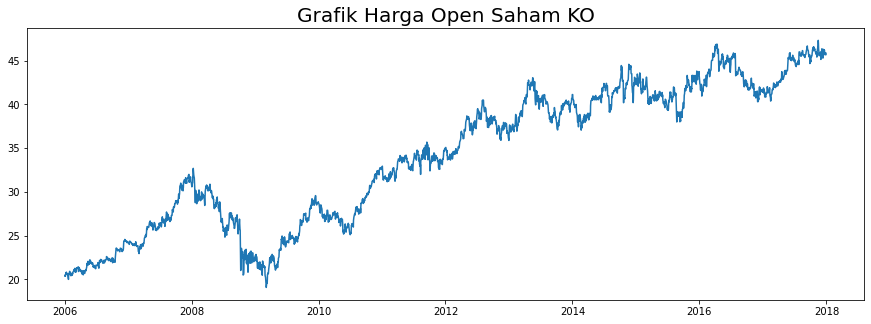

In [685]:
plt.figure(figsize=(15,5))
plt.plot(data['Date'], data['Open'])
plt.title('Grafik Harga Open Saham KO',
          fontsize=20);

In [686]:
#Features for training
cols = list(data)[1:]

data_cols = data[cols].astype(float)

In [687]:
cols

['Open', 'High', 'Low', 'Close', 'Volume']

In [688]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(data_cols)
data_cols_scaled = scaler.transform(data_cols)

In [689]:
dates = data['Date'].values
open  = data['Open'].values

In [690]:
dates = np.asarray(dates).astype('float32')
open = np.asarray(open).astype('float32')

# Pembuatan Arsitektur Model

In [691]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dates, open, test_size=0.2, random_state = 10 , shuffle=False)

In [692]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [697]:
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

train_set = windowed_dataset(Y_train, window_size=30, batch_size=32, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [698]:
# membuat fungsi call back
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1 or logs.get('val_mae')<0.1):  
      print("\n MAE sudah dibawah 10%")
      self.model.stop_training = True

callbacks = myCallback()

# Mulai Pelatihan Model

In [699]:
val_test = windowed_dataset(Y_test, window_size = 30, batch_size = 32, shuffle_buffer=1000)
history = model.fit(train_set, validation_data = val_test, epochs=100, callbacks=[callbacks])

Epoch 1/100
75/75 [==============================] - 68s 97ms/step - loss: 31.1954 - mae: 31.6954 - val_loss: 42.3553 - val_mae: 42.8553
Epoch 2/100
75/75 [==============================] - 5s 69ms/step - loss: 30.0262 - mae: 30.5262 - val_loss: 40.8598 - val_mae: 41.3598
Epoch 3/100
75/75 [==============================] - 5s 70ms/step - loss: 27.9907 - mae: 28.4907 - val_loss: 37.5254 - val_mae: 38.0254
Epoch 4/100
75/75 [==============================] - 6s 72ms/step - loss: 21.7613 - mae: 22.2612 - val_loss: 24.5734 - val_mae: 25.0734
Epoch 5/100
75/75 [==============================] - 5s 71ms/step - loss: 6.7993 - mae: 7.2857 - val_loss: 6.1095 - val_mae: 6.6083
Epoch 6/100
75/75 [==============================] - 5s 70ms/step - loss: 7.0494 - mae: 7.5362 - val_loss: 5.9081 - val_mae: 6.4067
Epoch 7/100
75/75 [==============================] - 5s 68ms/step - loss: 6.9138 - mae: 7.4003 - val_loss: 6.1715 - val_mae: 6.6708
Epoch 8/100
75/75 [==============================] - 5s 71m

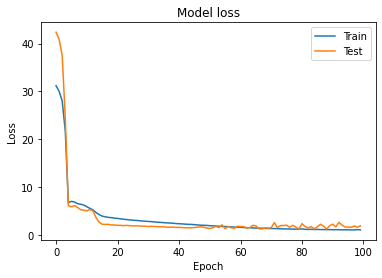

In [700]:
import matplotlib.pyplot as plt

# membuat plot untuk nilai Loss dari model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

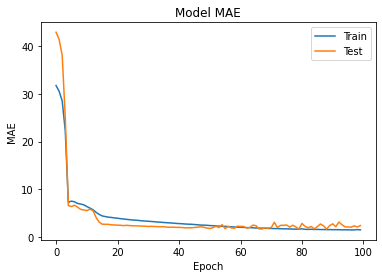

In [701]:
# membuat plot untuk MAE dari model
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()